In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
import time
import os

class FullyConnectedModel(nn.Module):
    def __init__(self, config_path=None, input_size=None, num_classes=None, **kwargs):
        super().__init__()
        if config_path:
            self.config = self.load_config(config_path)
        else:
            self.config = kwargs
        self.input_size = input_size or self.config.get('input_size', 784)
        self.num_classes = num_classes or self.config.get('num_classes', 10)
        self.layers = self._build_layers()

    def load_config(self, config_path):
        with open(config_path, 'r') as f:
            return json.load(f)

    def _build_layers(self):
        layers = []
        prev_size = self.input_size
        layer_config = self.config.get('layers', [])
        for layer_spec in layer_config:
            layer_type = layer_spec['type']
            if layer_type == 'linear':
                out_size = layer_spec['size']
                layers.append(nn.Linear(prev_size, out_size))
                prev_size = out_size
            elif layer_type == 'relu':
                layers.append(nn.ReLU())
            elif layer_type == 'sigmoid':
                layers.append(nn.Sigmoid())
            elif layer_type == 'tanh':
                layers.append(nn.Tanh())
            elif layer_type == 'dropout':
                rate = layer_spec.get('rate', 0.5)
                layers.append(nn.Dropout(rate))
            elif layer_type == 'batch_norm':
                layers.append(nn.BatchNorm1d(prev_size))
            elif layer_type == 'layer_norm':
                layers.append(nn.LayerNorm(prev_size))
        layers.append(nn.Linear(prev_size, self.num_classes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.layers(x)

def create_model_from_config(config_path, input_size=None, num_classes=None):
    return FullyConnectedModel(config_path, input_size, num_classes)

class MNISTDataset(Dataset):
    def __init__(self, train=True, transform=None):
        super().__init__()
        self.dataset = torchvision.datasets.MNIST(
            root='./data',
            train=train,
            download=True,
            transform=transform
        )
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]

def get_mnist_loaders(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    train_dataset = MNISTDataset(train=True, transform=transform)
    test_dataset = MNISTDataset(train=False, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

def run_epoch(model, data_loader, criterion, optimizer=None, device='cpu', is_test=False):
    if is_test:
        model.eval()
    else:
        model.train()
    total_loss = 0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.to(device), target.to(device)
        if not is_test and optimizer is not None:
            optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        if not is_test and optimizer is not None:
            loss.backward()
            optimizer.step()
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)
    return total_loss / len(data_loader), correct / total

def train_model(model, train_loader, test_loader, epochs=10, lr=0.001, device='cpu'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses, train_accs = [], []
    test_losses, test_accs = [], []
    for epoch in range(epochs):
        train_loss, train_acc = run_epoch(model, train_loader, criterion, optimizer, device, is_test=False)
        test_loss, test_acc = run_epoch(model, test_loader, criterion, None, device, is_test=True)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
        print('-' * 50)
    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_losses': test_losses,
        'test_accs': test_accs
    }

def plot_training_history(history, title=''):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(history['train_losses'], label='Train Loss')
    ax1.plot(history['test_losses'], label='Test Loss')
    ax1.set_title('Loss')
    ax1.legend()
    ax2.plot(history['train_accs'], label='Train Acc')
    ax2.plot(history['test_accs'], label='Test Acc')
    ax2.set_title('Accuracy')
    ax2.legend()
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Задание 1: Эксперименты с глубиной сети (30 баллов)

## 1.1 Сравнение моделей разной глубины (15 баллов)


In [ ]:
# Создайте и обучите модели с различным количеством слоев:
# - 1 слой (линейный классификатор)
# - 2 слоя (1 скрытый)
# - 3 слоя (2 скрытых)
# - 5 слоев (4 скрытых)
# - 7 слоев (6 скрытых)
#
# Для каждого варианта:
# - Сравните точность на train и test
# - Визуализируйте кривые обучения
# - Проанализируйте время обучения

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

Device: cuda


In [ ]:
train_loader, test_loader = get_mnist_loaders(batch_size=128)

INPUT_DIM = 28*28
OUTPUT_DIM = 10
LEARNING_RATE = 0.001
EPOCHS = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_loader, test_loader = get_mnist_loaders(batch_size=128)

model = FullyConnectedModel(config_path="config_example.json").to(device)

In [ ]:
import numpy as np

def depth_experiments(train_loader, test_loader,
                      input_dim=784, output_dim=10,
                      hidden_dim=256, epochs=10, lr=0.001, device='cpu'):
    depths = [0, 1, 2, 4, 6]
    final_accuracies = []
    best_test_accuracies_per_depth = []

    for num_hidden in depths:
        tag = f"depth_{num_hidden}"
        print(f"Running experiment for {tag}")
        layers = []
        for _ in range(num_hidden):
            layers.extend([
                {"type": "linear", "size": hidden_dim},
                {"type": "relu"},
            ])
        config = {"input_size": input_dim, "num_classes": output_dim, "layers": layers}
        model = FullyConnectedModel(**config).to(device)

        history = train_model(model, train_loader, test_loader, epochs=epochs, lr=lr, device=device)
        plot_training_history(history, title=tag)
        max_test_acc = max(history['test_accs'])
        best_test_accuracies_per_depth.append((num_hidden, max_test_acc))
        final_accuracies.append(history['test_accs'][-1])

    print("Summary of Best Test Accuracies per Depth")
    for depth, acc in best_test_accuracies_per_depth:
        print(f"Для глубины {depth}: лучший acc {acc:.4f}")

    avg_acc = np.mean(final_accuracies)
    print(f"[CHECK] Depth experiments avg final test accuracy: {avg_acc:.4f}")

    # Вторая серия экспериментов — Dropout + BatchNorm
    best_test_accuracies_per_depth_drop = []
    for num_hidden in depths:
        tag = f"overfit_{num_hidden}"
        print(f"Running Dropout+BN experiment for {tag}")
        layers = []
        for _ in range(num_hidden):
            layers.extend([
                {"type": "linear", "size": hidden_dim},
                {"type": "batch_norm"},
                {"type": "relu"},
                {"type": "dropout", "rate": 0.3},
            ])
        config = {"input_size": input_dim, "num_classes": output_dim, "layers": layers}
        model = FullyConnectedModel(**config).to(device)
        history = train_model(model, train_loader, test_loader, epochs=epochs, lr=lr, device=device)
        plot_training_history(history, title=f"Dropout+BN {tag}")
        max_test_acc_drop = max(history['test_accs'])
        best_test_accuracies_per_depth_drop.append((num_hidden, max_test_acc_drop))

    for depth, acc in best_test_accuracies_per_depth_drop:
        print(f"Для глубины {depth}: лучший acc {acc:.4f}")


Running experiment for depth_0
Epoch 1/10:
Train Loss: 0.4421, Train Acc: 0.8760
Test Loss: 0.2992, Test Acc: 0.9151
--------------------------------------------------
Epoch 2/10:
Train Loss: 0.3002, Train Acc: 0.9148
Test Loss: 0.2836, Test Acc: 0.9204
--------------------------------------------------
Epoch 3/10:
Train Loss: 0.2837, Train Acc: 0.9196
Test Loss: 0.2717, Test Acc: 0.9211
--------------------------------------------------
Epoch 4/10:
Train Loss: 0.2759, Train Acc: 0.9233
Test Loss: 0.2731, Test Acc: 0.9228
--------------------------------------------------
Epoch 5/10:
Train Loss: 0.2703, Train Acc: 0.9236
Test Loss: 0.2709, Test Acc: 0.9248
--------------------------------------------------
Epoch 6/10:
Train Loss: 0.2671, Train Acc: 0.9255
Test Loss: 0.2740, Test Acc: 0.9217
--------------------------------------------------
Epoch 7/10:
Train Loss: 0.2636, Train Acc: 0.9263
Test Loss: 0.2649, Test Acc: 0.9263
--------------------------------------------------
Epoch 8/10

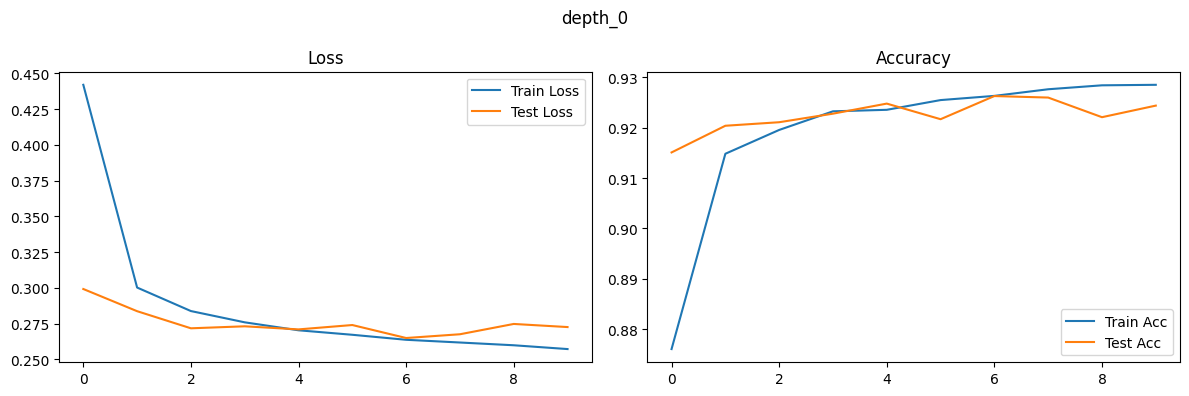

Running experiment for depth_1
Epoch 1/10:
Train Loss: 0.2664, Train Acc: 0.9224
Test Loss: 0.1364, Test Acc: 0.9594
--------------------------------------------------
Epoch 2/10:
Train Loss: 0.1084, Train Acc: 0.9680
Test Loss: 0.0916, Test Acc: 0.9710
--------------------------------------------------
Epoch 3/10:
Train Loss: 0.0724, Train Acc: 0.9783
Test Loss: 0.0790, Test Acc: 0.9744
--------------------------------------------------
Epoch 4/10:
Train Loss: 0.0523, Train Acc: 0.9833
Test Loss: 0.0764, Test Acc: 0.9768
--------------------------------------------------
Epoch 5/10:
Train Loss: 0.0407, Train Acc: 0.9876
Test Loss: 0.0710, Test Acc: 0.9769
--------------------------------------------------
Epoch 6/10:
Train Loss: 0.0308, Train Acc: 0.9906
Test Loss: 0.0684, Test Acc: 0.9792
--------------------------------------------------
Epoch 7/10:
Train Loss: 0.0259, Train Acc: 0.9917
Test Loss: 0.0625, Test Acc: 0.9814
--------------------------------------------------
Epoch 8/10

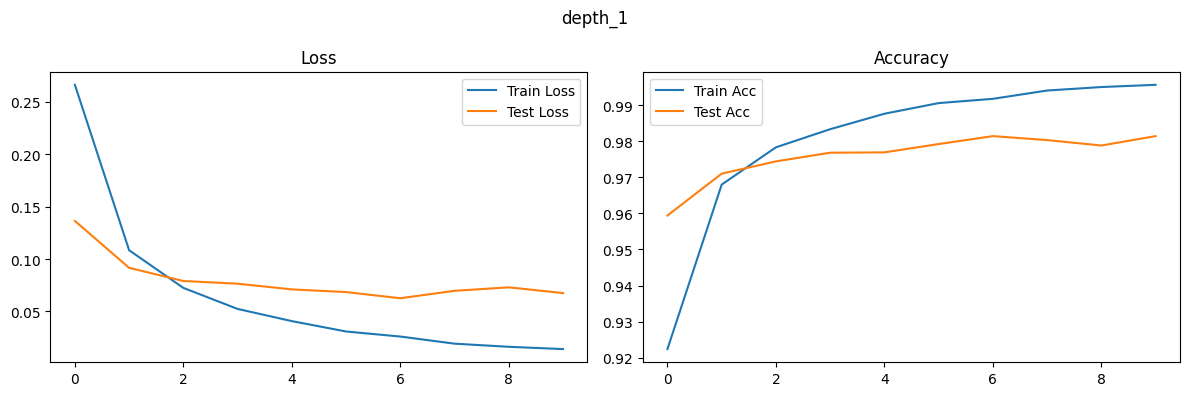

Running experiment for depth_2
Epoch 1/10:
Train Loss: 0.2517, Train Acc: 0.9257
Test Loss: 0.1287, Test Acc: 0.9578
--------------------------------------------------
Epoch 2/10:
Train Loss: 0.0960, Train Acc: 0.9706
Test Loss: 0.0858, Test Acc: 0.9743
--------------------------------------------------
Epoch 3/10:
Train Loss: 0.0657, Train Acc: 0.9792
Test Loss: 0.0714, Test Acc: 0.9761
--------------------------------------------------
Epoch 4/10:
Train Loss: 0.0471, Train Acc: 0.9845
Test Loss: 0.0675, Test Acc: 0.9785
--------------------------------------------------
Epoch 5/10:
Train Loss: 0.0368, Train Acc: 0.9880
Test Loss: 0.0654, Test Acc: 0.9805
--------------------------------------------------
Epoch 6/10:
Train Loss: 0.0294, Train Acc: 0.9900
Test Loss: 0.0748, Test Acc: 0.9785
--------------------------------------------------
Epoch 7/10:
Train Loss: 0.0261, Train Acc: 0.9910
Test Loss: 0.0783, Test Acc: 0.9784
--------------------------------------------------
Epoch 8/10

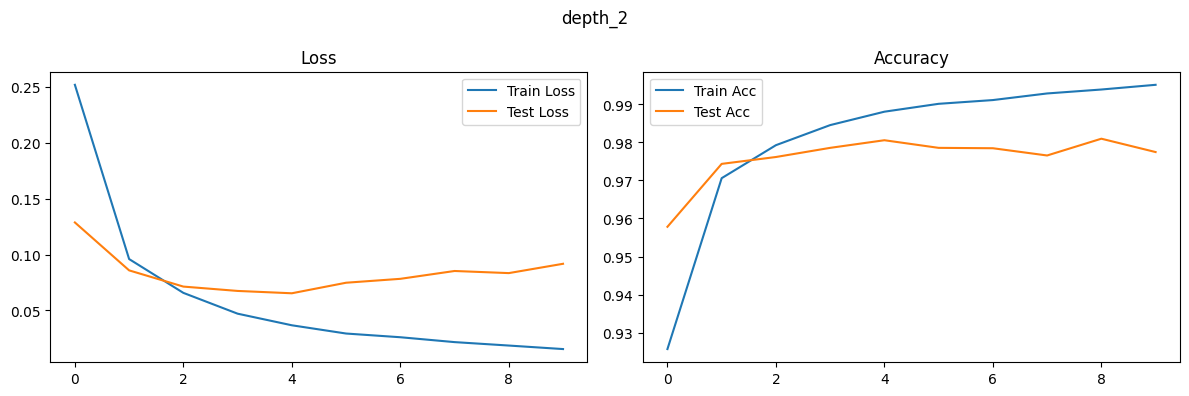

Running experiment for depth_4
Epoch 1/10:
Train Loss: 0.2760, Train Acc: 0.9133
Test Loss: 0.1322, Test Acc: 0.9576
--------------------------------------------------
Epoch 2/10:
Train Loss: 0.1046, Train Acc: 0.9681
Test Loss: 0.0942, Test Acc: 0.9724
--------------------------------------------------
Epoch 3/10:
Train Loss: 0.0745, Train Acc: 0.9768
Test Loss: 0.0796, Test Acc: 0.9754
--------------------------------------------------
Epoch 4/10:
Train Loss: 0.0595, Train Acc: 0.9818
Test Loss: 0.0756, Test Acc: 0.9757
--------------------------------------------------
Epoch 5/10:
Train Loss: 0.0474, Train Acc: 0.9851
Test Loss: 0.0773, Test Acc: 0.9777
--------------------------------------------------
Epoch 6/10:
Train Loss: 0.0400, Train Acc: 0.9875
Test Loss: 0.0738, Test Acc: 0.9796
--------------------------------------------------
Epoch 7/10:
Train Loss: 0.0363, Train Acc: 0.9885
Test Loss: 0.0735, Test Acc: 0.9798
--------------------------------------------------
Epoch 8/10

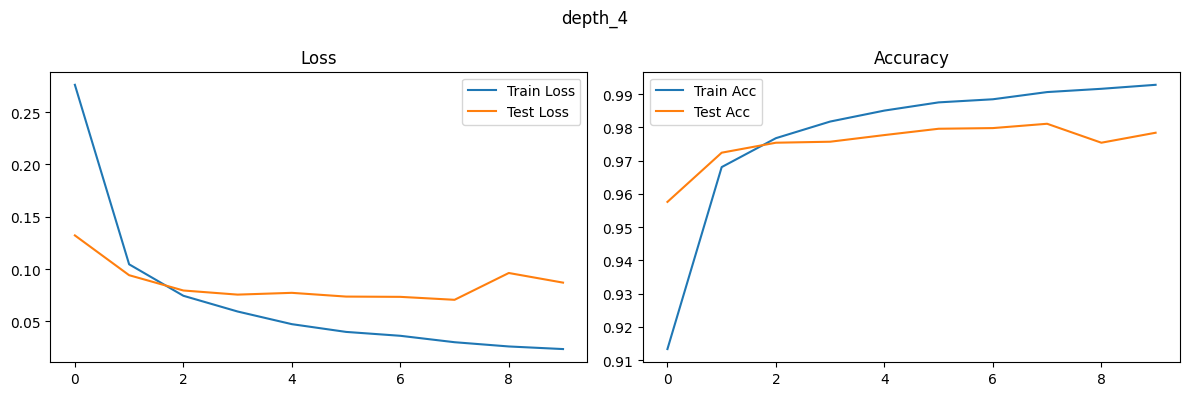

Running experiment for depth_6
Epoch 1/10:
Train Loss: 0.3327, Train Acc: 0.8942
Test Loss: 0.1354, Test Acc: 0.9585
--------------------------------------------------
Epoch 2/10:
Train Loss: 0.1219, Train Acc: 0.9647
Test Loss: 0.1042, Test Acc: 0.9686
--------------------------------------------------
Epoch 3/10:
Train Loss: 0.0889, Train Acc: 0.9740
Test Loss: 0.1029, Test Acc: 0.9721
--------------------------------------------------
Epoch 4/10:
Train Loss: 0.0725, Train Acc: 0.9780
Test Loss: 0.0934, Test Acc: 0.9736
--------------------------------------------------
Epoch 5/10:
Train Loss: 0.0563, Train Acc: 0.9836
Test Loss: 0.0887, Test Acc: 0.9759
--------------------------------------------------
Epoch 6/10:
Train Loss: 0.0523, Train Acc: 0.9844
Test Loss: 0.0843, Test Acc: 0.9772
--------------------------------------------------
Epoch 7/10:
Train Loss: 0.0428, Train Acc: 0.9873
Test Loss: 0.0882, Test Acc: 0.9763
--------------------------------------------------
Epoch 8/10

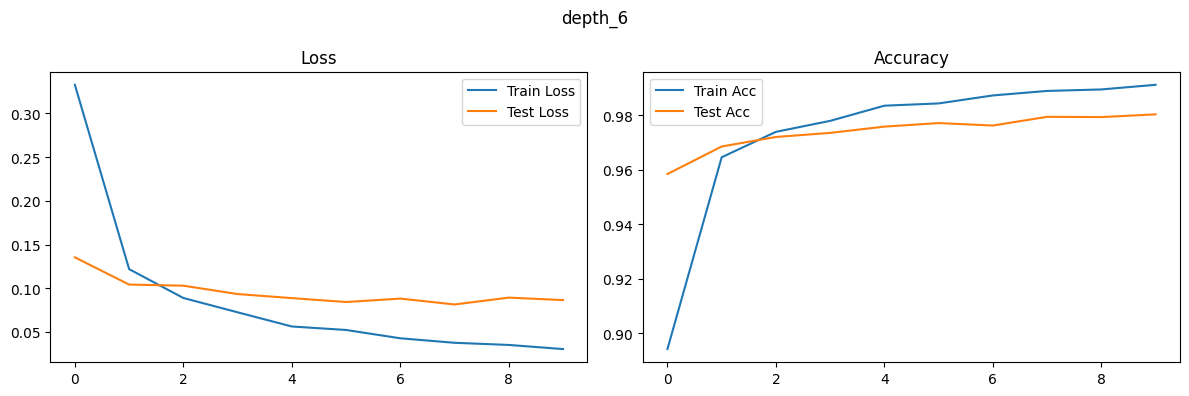

Summary of Best Test Accuracies per Depth
Для глубины 0: лучший acc 0.9263
Для глубины 1: лучший acc 0.9814
Для глубины 2: лучший acc 0.9809
Для глубины 4: лучший acc 0.9811
Для глубины 6: лучший acc 0.9804
[CHECK] Depth experiments avg final test accuracy: 0.9684
Running Dropout+BN experiment for overfit_0
Epoch 1/10:
Train Loss: 0.4316, Train Acc: 0.8793
Test Loss: 0.2954, Test Acc: 0.9164
--------------------------------------------------
Epoch 2/10:
Train Loss: 0.3000, Train Acc: 0.9146
Test Loss: 0.2766, Test Acc: 0.9195
--------------------------------------------------
Epoch 3/10:
Train Loss: 0.2840, Train Acc: 0.9197
Test Loss: 0.2766, Test Acc: 0.9217
--------------------------------------------------
Epoch 4/10:
Train Loss: 0.2761, Train Acc: 0.9226
Test Loss: 0.2767, Test Acc: 0.9210
--------------------------------------------------
Epoch 5/10:
Train Loss: 0.2705, Train Acc: 0.9233
Test Loss: 0.2767, Test Acc: 0.9197
--------------------------------------------------
Epoch 

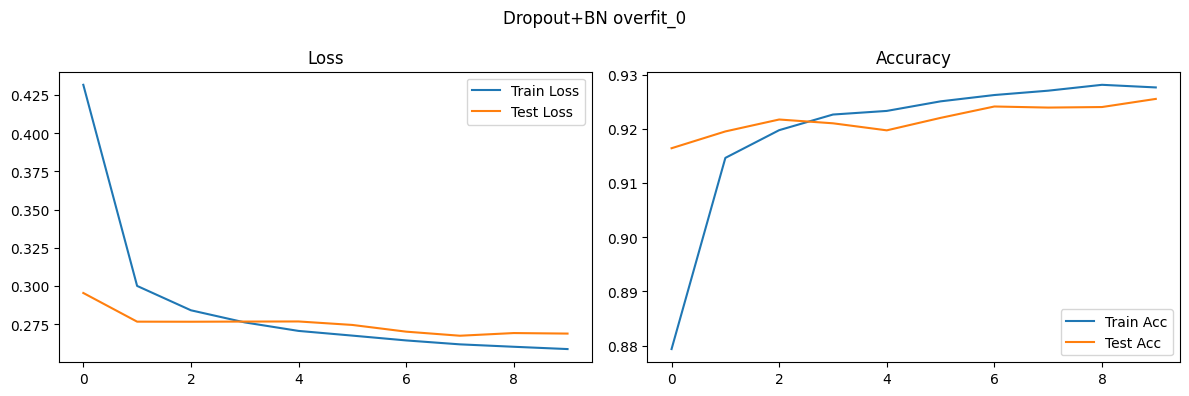

Running Dropout+BN experiment for overfit_1
Epoch 1/10:
Train Loss: 0.2938, Train Acc: 0.9187
Test Loss: 0.1393, Test Acc: 0.9600
--------------------------------------------------
Epoch 2/10:
Train Loss: 0.1474, Train Acc: 0.9562
Test Loss: 0.1020, Test Acc: 0.9699
--------------------------------------------------
Epoch 3/10:
Train Loss: 0.1123, Train Acc: 0.9678
Test Loss: 0.0898, Test Acc: 0.9725
--------------------------------------------------
Epoch 4/10:
Train Loss: 0.0933, Train Acc: 0.9714
Test Loss: 0.0809, Test Acc: 0.9754
--------------------------------------------------
Epoch 5/10:
Train Loss: 0.0829, Train Acc: 0.9751
Test Loss: 0.0736, Test Acc: 0.9772
--------------------------------------------------
Epoch 6/10:
Train Loss: 0.0709, Train Acc: 0.9786
Test Loss: 0.0729, Test Acc: 0.9771
--------------------------------------------------
Epoch 7/10:
Train Loss: 0.0639, Train Acc: 0.9801
Test Loss: 0.0707, Test Acc: 0.9795
------------------------------------------------

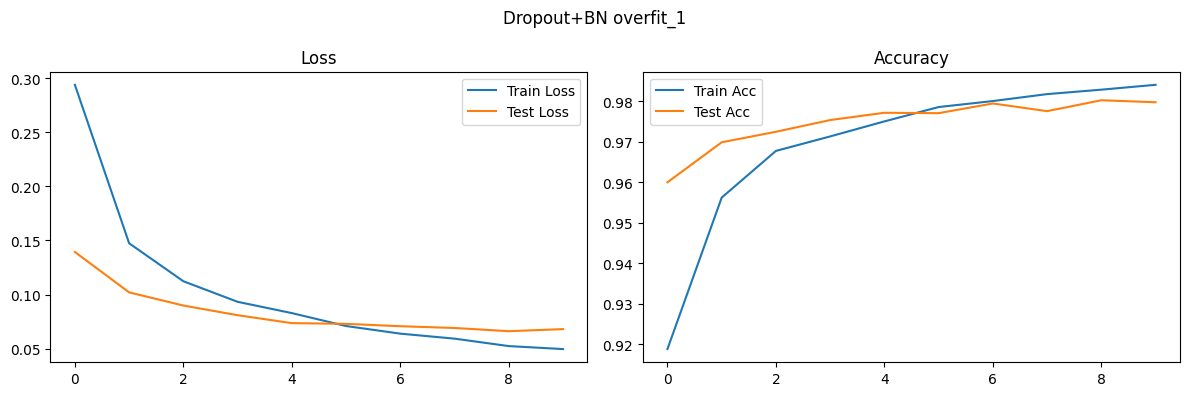

Running Dropout+BN experiment for overfit_2
Epoch 1/10:
Train Loss: 0.2842, Train Acc: 0.9181
Test Loss: 0.1104, Test Acc: 0.9648
--------------------------------------------------
Epoch 2/10:
Train Loss: 0.1378, Train Acc: 0.9574
Test Loss: 0.0798, Test Acc: 0.9758
--------------------------------------------------
Epoch 3/10:
Train Loss: 0.1057, Train Acc: 0.9672
Test Loss: 0.0718, Test Acc: 0.9770
--------------------------------------------------
Epoch 4/10:
Train Loss: 0.0904, Train Acc: 0.9715
Test Loss: 0.0655, Test Acc: 0.9790
--------------------------------------------------
Epoch 5/10:
Train Loss: 0.0776, Train Acc: 0.9747
Test Loss: 0.0605, Test Acc: 0.9816
--------------------------------------------------
Epoch 6/10:
Train Loss: 0.0689, Train Acc: 0.9776
Test Loss: 0.0561, Test Acc: 0.9829
--------------------------------------------------
Epoch 7/10:
Train Loss: 0.0628, Train Acc: 0.9797
Test Loss: 0.0609, Test Acc: 0.9797
------------------------------------------------

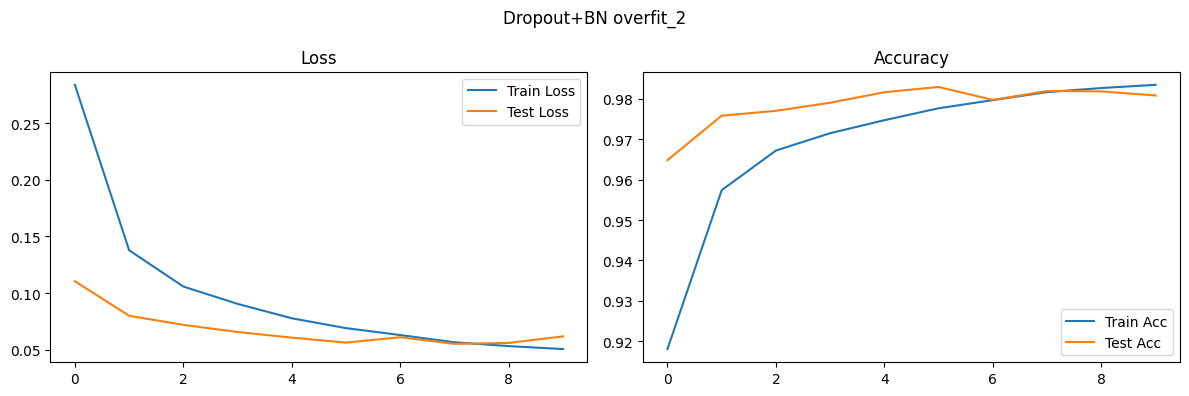

Running Dropout+BN experiment for overfit_4
Epoch 1/10:
Train Loss: 0.3428, Train Acc: 0.8978
Test Loss: 0.1201, Test Acc: 0.9639
--------------------------------------------------
Epoch 2/10:
Train Loss: 0.1701, Train Acc: 0.9491
Test Loss: 0.0920, Test Acc: 0.9717
--------------------------------------------------
Epoch 3/10:
Train Loss: 0.1372, Train Acc: 0.9581
Test Loss: 0.0741, Test Acc: 0.9777
--------------------------------------------------
Epoch 4/10:
Train Loss: 0.1185, Train Acc: 0.9641
Test Loss: 0.0749, Test Acc: 0.9783
--------------------------------------------------
Epoch 5/10:
Train Loss: 0.1046, Train Acc: 0.9683
Test Loss: 0.0734, Test Acc: 0.9777
--------------------------------------------------
Epoch 6/10:
Train Loss: 0.0961, Train Acc: 0.9708
Test Loss: 0.0630, Test Acc: 0.9819
--------------------------------------------------
Epoch 7/10:
Train Loss: 0.0859, Train Acc: 0.9736
Test Loss: 0.0647, Test Acc: 0.9806
------------------------------------------------

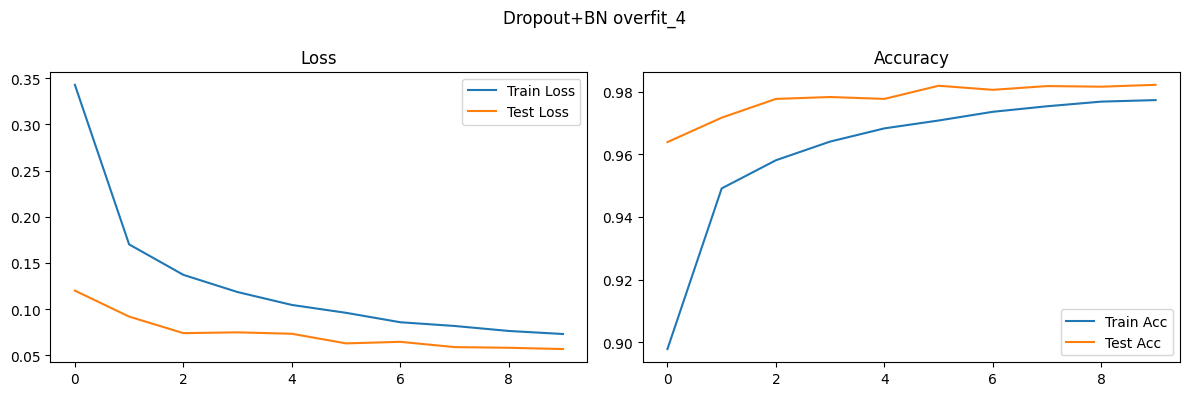

Running Dropout+BN experiment for overfit_6
Epoch 1/10:
Train Loss: 0.4570, Train Acc: 0.8624
Test Loss: 0.1262, Test Acc: 0.9615
--------------------------------------------------
Epoch 2/10:
Train Loss: 0.2096, Train Acc: 0.9406
Test Loss: 0.1008, Test Acc: 0.9702
--------------------------------------------------
Epoch 3/10:
Train Loss: 0.1731, Train Acc: 0.9506
Test Loss: 0.0891, Test Acc: 0.9737
--------------------------------------------------
Epoch 4/10:
Train Loss: 0.1463, Train Acc: 0.9586
Test Loss: 0.0796, Test Acc: 0.9767
--------------------------------------------------
Epoch 5/10:
Train Loss: 0.1338, Train Acc: 0.9623
Test Loss: 0.0801, Test Acc: 0.9761
--------------------------------------------------
Epoch 6/10:
Train Loss: 0.1172, Train Acc: 0.9661
Test Loss: 0.0782, Test Acc: 0.9761
--------------------------------------------------
Epoch 7/10:
Train Loss: 0.1111, Train Acc: 0.9683
Test Loss: 0.0734, Test Acc: 0.9786
------------------------------------------------

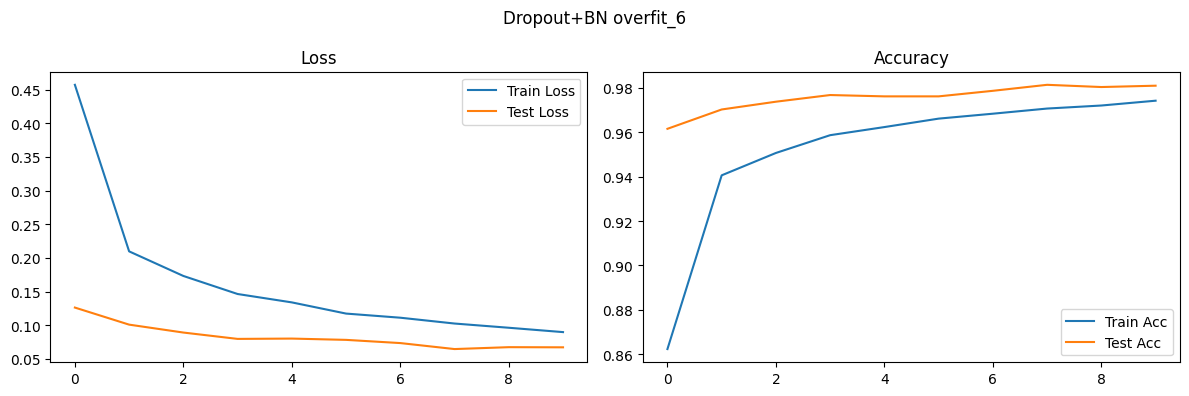

Для глубины 0: лучший acc 0.9255
Для глубины 1: лучший acc 0.9803
Для глубины 2: лучший acc 0.9829
Для глубины 4: лучший acc 0.9822
Для глубины 6: лучший acc 0.9813


In [ ]:
depth_experiments(train_loader, test_loader,
                  input_dim=INPUT_DIM, output_dim=OUTPUT_DIM,
                  hidden_dim=256, epochs=EPOCHS, lr=LEARNING_RATE, device=device)


## 1.2 Анализ переобучения (15 баллов)

In [ ]:
# Исследуйте влияние глубины на переобучение:
# - Постройте графики train/test accuracy по эпохам
# - Определите оптимальную глубину для каждого датасета
# - Добавьте Dropout и BatchNorm, сравните результаты
# - Проанализируйте, когда начинается переобучение

В общем при увеличении количества слоев увеличивается accuracy

При увеличении количества слоев немного растет время работы.

Epoch 1/10:
Train Loss: 1.1160, Train Acc: 0.6748
Test Loss: 0.2654, Test Acc: 0.9446
--------------------------------------------------
Epoch 2/10:
Train Loss: 0.5339, Train Acc: 0.8649
Test Loss: 0.1916, Test Acc: 0.9532
--------------------------------------------------
Epoch 3/10:
Train Loss: 0.4365, Train Acc: 0.8932
Test Loss: 0.1533, Test Acc: 0.9645
--------------------------------------------------
Epoch 4/10:
Train Loss: 0.3877, Train Acc: 0.9052
Test Loss: 0.1360, Test Acc: 0.9667
--------------------------------------------------
Epoch 5/10:
Train Loss: 0.3550, Train Acc: 0.9127
Test Loss: 0.1474, Test Acc: 0.9685
--------------------------------------------------
Epoch 6/10:
Train Loss: 0.3434, Train Acc: 0.9155
Test Loss: 0.1270, Test Acc: 0.9716
--------------------------------------------------
Epoch 7/10:
Train Loss: 0.3131, Train Acc: 0.9241
Test Loss: 0.1177, Test Acc: 0.9726
--------------------------------------------------
Epoch 8/10:
Train Loss: 0.3119, Train Acc

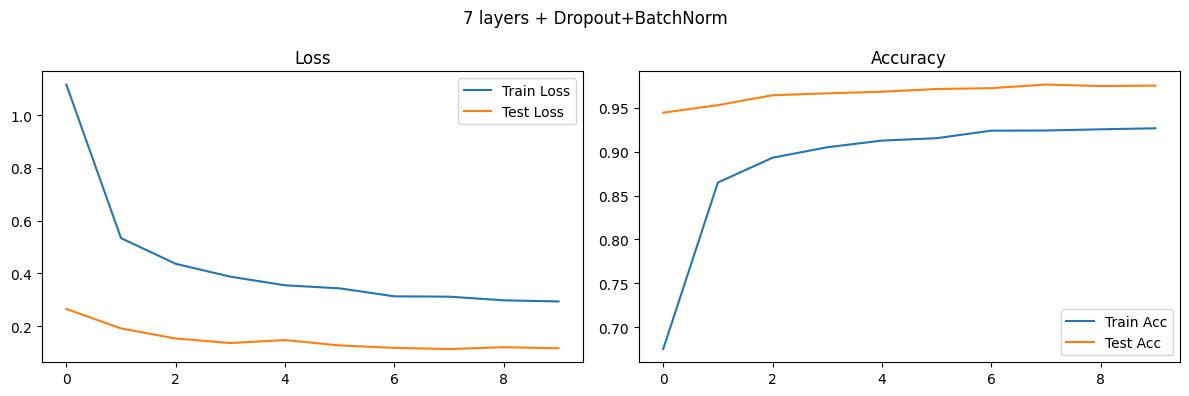

Final Train Acc = 0.9268, Test Acc = 0.9755


In [ ]:
# Конфиг с dropout и batchnorm
deep_layers = [
    {'type': 'linear', 'size': 512}, {'type': 'relu'}, {'type': 'dropout', 'rate': 0.3}, {'type': 'batch_norm'},
    {'type': 'linear', 'size': 256}, {'type': 'relu'}, {'type': 'dropout', 'rate': 0.3}, {'type': 'batch_norm'},
    {'type': 'linear', 'size': 128}, {'type': 'relu'}, {'type': 'dropout', 'rate': 0.3}, {'type': 'batch_norm'},
    {'type': 'linear', 'size': 64}, {'type': 'relu'}, {'type': 'dropout', 'rate': 0.3}, {'type': 'batch_norm'},
    {'type': 'linear', 'size': 32}, {'type': 'relu'}, {'type': 'dropout', 'rate': 0.3}, {'type': 'batch_norm'},
    {'type': 'linear', 'size': 16}, {'type': 'relu'}, {'type': 'dropout', 'rate': 0.3}, {'type': 'batch_norm'},
]

config = {'layers': deep_layers, 'input_size': INPUT_DIM, 'num_classes': OUTPUT_DIM}
model = FullyConnectedModel(**config).to(device)
history = train_model(model, train_loader, test_loader, epochs=10, lr=0.001, device=device)
plot_training_history(history, title='7 layers + Dropout+BatchNorm')

print(f"Final Train Acc = {history['train_accs'][-1]:.4f}, Test Acc = {history['test_accs'][-1]:.4f}")

# Задание 2: Эксперименты с шириной сети (25 баллов)

## 2.1 Сравнение моделей разной ширины (15 баллов)

In [ ]:
# Создайте модели с различной шириной слоев:
# - Узкие слои: [64, 32, 16]
# - Средние слои: [256, 128, 64]
# - Широкие слои: [1024, 512, 256]
# - Очень широкие слои: [2048, 1024, 512]
#
# Для каждого варианта:
# - Поддерживайте одинаковую глубину (3 слоя)
# - Сравните точность и время обучения
# - Проанализируйте количество параметров


narrow:
Epoch 1/10:
Train Loss: 0.5203, Train Acc: 0.8386
Test Loss: 0.2210, Test Acc: 0.9333
--------------------------------------------------
Epoch 2/10:
Train Loss: 0.1869, Train Acc: 0.9454
Test Loss: 0.1570, Test Acc: 0.9518
--------------------------------------------------
Epoch 3/10:
Train Loss: 0.1380, Train Acc: 0.9590
Test Loss: 0.1320, Test Acc: 0.9592
--------------------------------------------------
Epoch 4/10:
Train Loss: 0.1116, Train Acc: 0.9667
Test Loss: 0.1159, Test Acc: 0.9640
--------------------------------------------------
Epoch 5/10:
Train Loss: 0.0929, Train Acc: 0.9722
Test Loss: 0.1122, Test Acc: 0.9665
--------------------------------------------------
Epoch 6/10:
Train Loss: 0.0799, Train Acc: 0.9755
Test Loss: 0.0968, Test Acc: 0.9699
--------------------------------------------------
Epoch 7/10:
Train Loss: 0.0684, Train Acc: 0.9789
Test Loss: 0.0900, Test Acc: 0.9712
--------------------------------------------------
Epoch 8/10:
Train Loss: 0.0597, 

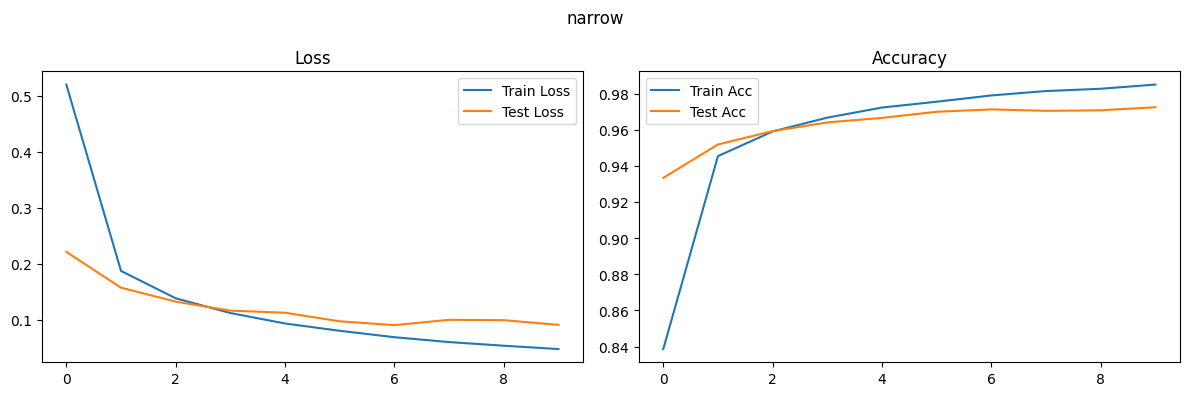

Parameters: 53018 | Time: 146.1 sec

medium:
Epoch 1/10:
Train Loss: 0.3151, Train Acc: 0.9056
Test Loss: 0.1454, Test Acc: 0.9548
--------------------------------------------------
Epoch 2/10:
Train Loss: 0.1140, Train Acc: 0.9649
Test Loss: 0.1029, Test Acc: 0.9672
--------------------------------------------------
Epoch 3/10:
Train Loss: 0.0758, Train Acc: 0.9768
Test Loss: 0.0864, Test Acc: 0.9732
--------------------------------------------------
Epoch 4/10:
Train Loss: 0.0587, Train Acc: 0.9811
Test Loss: 0.0817, Test Acc: 0.9746
--------------------------------------------------
Epoch 5/10:
Train Loss: 0.0449, Train Acc: 0.9848
Test Loss: 0.0712, Test Acc: 0.9784
--------------------------------------------------
Epoch 6/10:
Train Loss: 0.0372, Train Acc: 0.9877
Test Loss: 0.0711, Test Acc: 0.9774
--------------------------------------------------
Epoch 7/10:
Train Loss: 0.0315, Train Acc: 0.9896
Test Loss: 0.0801, Test Acc: 0.9791
-----------------------------------------------

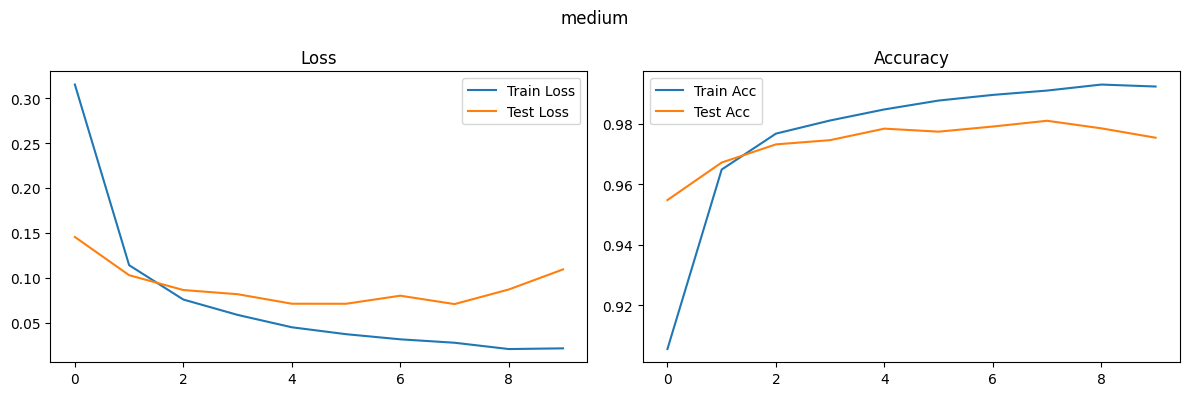

Parameters: 242762 | Time: 147.4 sec

wide:
Epoch 1/10:
Train Loss: 0.2203, Train Acc: 0.9317
Test Loss: 0.1048, Test Acc: 0.9662
--------------------------------------------------
Epoch 2/10:
Train Loss: 0.0880, Train Acc: 0.9732
Test Loss: 0.0855, Test Acc: 0.9713
--------------------------------------------------
Epoch 3/10:
Train Loss: 0.0627, Train Acc: 0.9809
Test Loss: 0.0782, Test Acc: 0.9773
--------------------------------------------------
Epoch 4/10:
Train Loss: 0.0486, Train Acc: 0.9846
Test Loss: 0.0965, Test Acc: 0.9702
--------------------------------------------------
Epoch 5/10:
Train Loss: 0.0397, Train Acc: 0.9877
Test Loss: 0.0734, Test Acc: 0.9782
--------------------------------------------------
Epoch 6/10:
Train Loss: 0.0321, Train Acc: 0.9897
Test Loss: 0.0765, Test Acc: 0.9790
--------------------------------------------------
Epoch 7/10:
Train Loss: 0.0274, Train Acc: 0.9912
Test Loss: 0.0771, Test Acc: 0.9787
------------------------------------------------

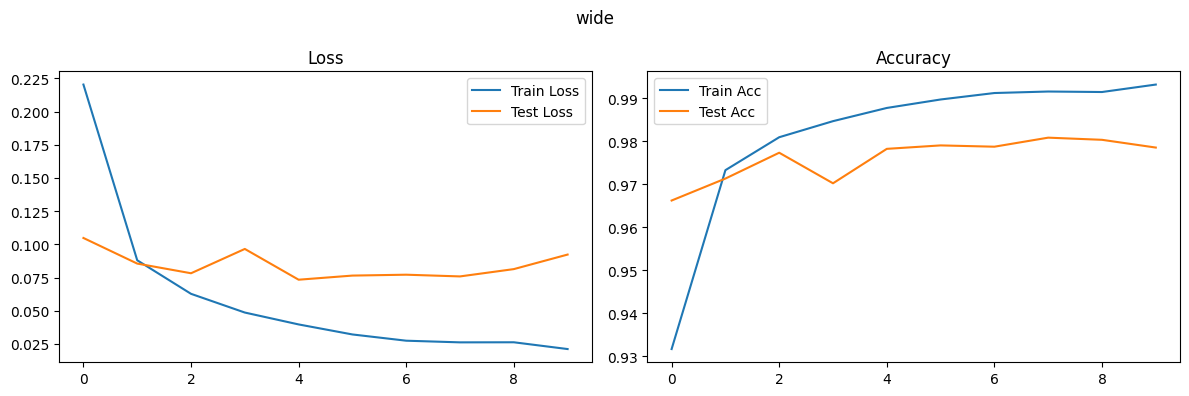

Parameters: 1462538 | Time: 145.5 sec

very_wide:
Epoch 1/10:
Train Loss: 0.2076, Train Acc: 0.9366
Test Loss: 0.1198, Test Acc: 0.9617
--------------------------------------------------
Epoch 2/10:
Train Loss: 0.0897, Train Acc: 0.9729
Test Loss: 0.0977, Test Acc: 0.9707
--------------------------------------------------
Epoch 3/10:
Train Loss: 0.0632, Train Acc: 0.9802
Test Loss: 0.0928, Test Acc: 0.9721
--------------------------------------------------
Epoch 4/10:
Train Loss: 0.0513, Train Acc: 0.9847
Test Loss: 0.0873, Test Acc: 0.9749
--------------------------------------------------
Epoch 5/10:
Train Loss: 0.0414, Train Acc: 0.9870
Test Loss: 0.0884, Test Acc: 0.9769
--------------------------------------------------
Epoch 6/10:
Train Loss: 0.0355, Train Acc: 0.9892
Test Loss: 0.0728, Test Acc: 0.9796
--------------------------------------------------
Epoch 7/10:
Train Loss: 0.0323, Train Acc: 0.9895
Test Loss: 0.0638, Test Acc: 0.9829
------------------------------------------

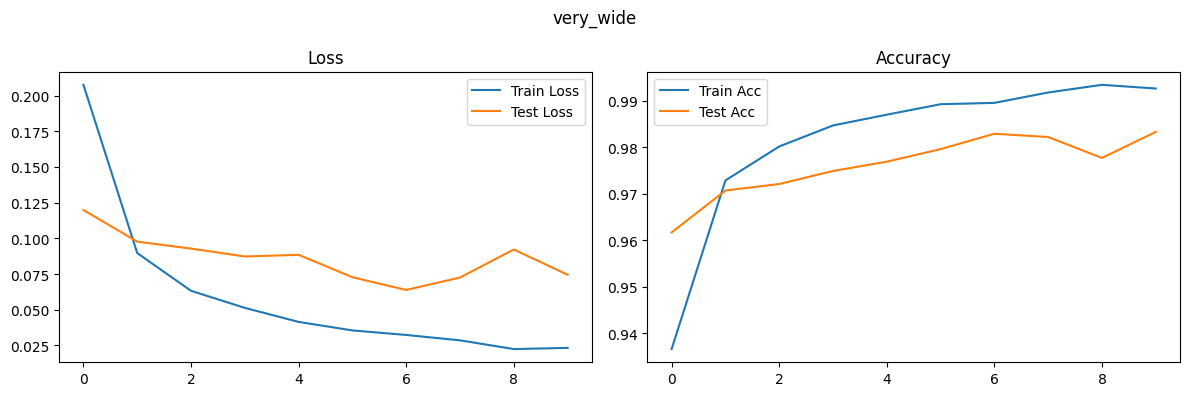

Parameters: 4235786 | Time: 158.7 sec
narrow: Final Train Acc = 0.9849, Test Acc = 0.9724, Time = 146.1 sec, Parameters = 53018
medium: Final Train Acc = 0.9923, Test Acc = 0.9754, Time = 147.4 sec, Parameters = 242762
wide: Final Train Acc = 0.9931, Test Acc = 0.9785, Time = 145.5 sec, Parameters = 1462538
very_wide: Final Train Acc = 0.9926, Test Acc = 0.9833, Time = 158.7 sec, Parameters = 4235786


In [ ]:
width_variants = {
    'narrow': [64, 32, 16],
    'medium': [256, 128, 64],
    'wide': [1024, 512, 256],
    'very_wide': [2048, 1024, 512]
}
width_results = {}
width_times = {}

for name, sizes in width_variants.items():
    layers = []
    prev = INPUT_DIM
    for size in sizes:
        layers.append({'type': 'linear', 'size': size})
        layers.append({'type': 'relu'})
        prev = size
    config = {'layers': layers, 'input_size': INPUT_DIM, 'num_classes': OUTPUT_DIM}
    print(f"\n{name}:")
    model = FullyConnectedModel(**config).to(device)
    start_time = time.time()
    history = train_model(model, train_loader, test_loader, epochs=10, lr=0.001, device=device)
    t = time.time() - start_time
    width_results[name] = history
    width_times[name] = t
    plot_training_history(history, title=name)
    print(f"Parameters: {count_parameters(model)} | Time: {t:.1f} sec")

for name in width_variants.keys():
    print(f"{name}: Final Train Acc = {width_results[name]['train_accs'][-1]:.4f}, Test Acc = {width_results[name]['test_accs'][-1]:.4f}, Time = {width_times[name]:.1f} sec, Parameters = {count_parameters(FullyConnectedModel(layers=[{'type': 'linear', 'size': s} for s in width_variants[name] ], input_size=input_size, num_classes=num_classes))}")


## Узкие слои показали самый худший результат. Другие слои показали почти одинаковые результаты



## 2.2 Оптимизация архитектуры (10 баллов)

In [ ]:
# Найдите оптимальную архитектуру:
# - Используйте grid search для поиска лучшей комбинации
# - Попробуйте различные схемы изменения ширины (расширение, сужение, постоянная)
# - Визуализируйте результаты в виде heatmap

In [ ]:
from itertools import product

widths = [64, 128, 256, 512]
width_combinations = list(product(widths, repeat=3))

results = []
comb_labels = []

for comb in width_combinations:
    name = f"{comb[0]}-{comb[1]}-{comb[2]}"
    comb_labels.append(name)
    layers = []
    for size in comb:
        layers.append({'type': 'linear', 'size': size})
        layers.append({'type': 'relu'})
    config = {'layers': layers, 'input_size': INPUT_DIM, 'num_classes': OUTPUT_DIM}
    print(f"Архитектура: {name}")
    model = FullyConnectedModel(**config).to(device)
    history = train_model(model, train_loader, test_loader, epochs=10, lr=0.001, device=device)
    results.append(history['test_accs'][-1])


Архитектура: 64-64-64
Epoch 1/10:
Train Loss: 0.3912, Train Acc: 0.8835
Test Loss: 0.1932, Test Acc: 0.9401
--------------------------------------------------
Epoch 2/10:
Train Loss: 0.1600, Train Acc: 0.9509
Test Loss: 0.1430, Test Acc: 0.9534
--------------------------------------------------
Epoch 3/10:
Train Loss: 0.1189, Train Acc: 0.9629
Test Loss: 0.1136, Test Acc: 0.9642
--------------------------------------------------
Epoch 4/10:
Train Loss: 0.0922, Train Acc: 0.9710
Test Loss: 0.1022, Test Acc: 0.9670
--------------------------------------------------
Epoch 5/10:
Train Loss: 0.0788, Train Acc: 0.9756
Test Loss: 0.0932, Test Acc: 0.9705
--------------------------------------------------
Epoch 6/10:
Train Loss: 0.0687, Train Acc: 0.9782
Test Loss: 0.0867, Test Acc: 0.9731
--------------------------------------------------
Epoch 7/10:
Train Loss: 0.0594, Train Acc: 0.9804
Test Loss: 0.0933, Test Acc: 0.9716
--------------------------------------------------
Epoch 8/10:
Train L

In [13]:
import numpy as np

fixed_w3 = 128

heatmap_matrix = np.zeros((len(widths), len(widths)))

for i, w1 in enumerate(widths):
    for j, w2 in enumerate(widths):
        idx = width_combinations.index((w1, w2, fixed_w3))
        heatmap_matrix[i, j] = results[idx]


NameError: name 'width_combinations' is not defined

In [12]:
#import seaborn as sns
#import matplotlib.pyplot as plt

#plt.figure(figsize=(8, 6))
#sns.heatmap(
#    heatmap_matrix,
#    annot=True, fmt=".4f", cmap="YlGnBu",
#   xticklabels=widths, yticklabels=widths
#)
#plt.xlabel("Width of 2nd layer (w2)")
#plt.ylabel("Width of 1st layer (w1)")
#plt.title(f"Test accuracy (3rd layer fixed: {fixed_w3})")
#plt.tight_layout()


# Задание 3: Эксперименты с регуляризацией (25 баллов)

## 3.1 Сравнение техник регуляризации (15 баллов)

In [ ]:
# Исследуйте различные техники регуляризации:
# - Без регуляризации
# - Только Dropout (разные коэффициенты: 0.1, 0.3, 0.5)
# - Только BatchNorm
# - Dropout + BatchNorm
# - L2 регуляризация (weight decay)
#
# Для каждого варианта:
# - Используйте одинаковую архитектуру
# - Сравните финальную точность
# - Проанализируйте стабильность обучения
# - Визуализируйте распределение весов

Без регуляризации:
Epoch 1/10:
Train Loss: 0.3025, Train Acc: 0.9079
Test Loss: 0.1326, Test Acc: 0.9589
--------------------------------------------------
Epoch 2/10:
Train Loss: 0.1147, Train Acc: 0.9647
Test Loss: 0.0998, Test Acc: 0.9667
--------------------------------------------------
Epoch 3/10:
Train Loss: 0.0754, Train Acc: 0.9766
Test Loss: 0.0992, Test Acc: 0.9693
--------------------------------------------------
Epoch 4/10:
Train Loss: 0.0585, Train Acc: 0.9812
Test Loss: 0.0742, Test Acc: 0.9776
--------------------------------------------------
Epoch 5/10:
Train Loss: 0.0436, Train Acc: 0.9858
Test Loss: 0.0810, Test Acc: 0.9744
--------------------------------------------------
Epoch 6/10:
Train Loss: 0.0377, Train Acc: 0.9880
Test Loss: 0.0719, Test Acc: 0.9786
--------------------------------------------------
Epoch 7/10:
Train Loss: 0.0305, Train Acc: 0.9900
Test Loss: 0.0831, Test Acc: 0.9750
--------------------------------------------------
Epoch 8/10:
Train Loss

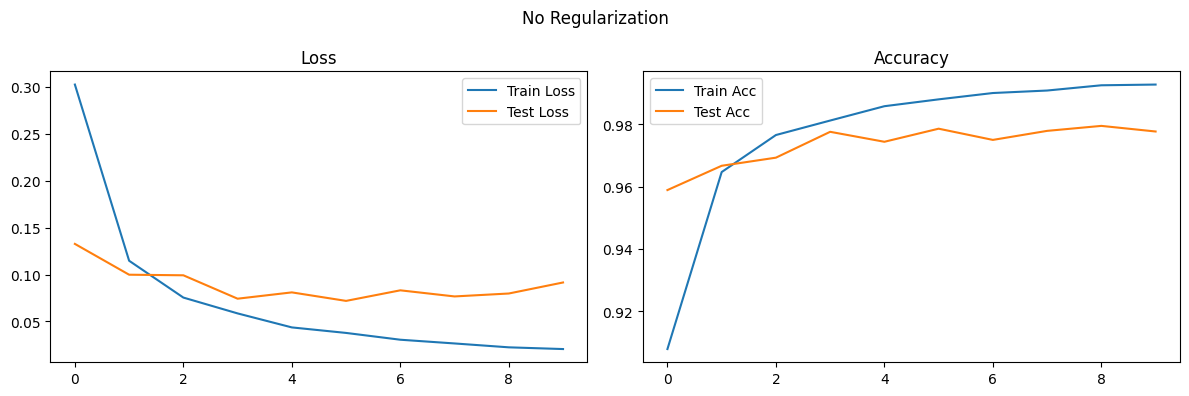

In [ ]:
# Без регуляризации
layers = [
    {'type': 'linear', 'size': 256}, {'type': 'relu'},
    {'type': 'linear', 'size': 128}, {'type': 'relu'},
    {'type': 'linear', 'size': 64}, {'type': 'relu'},
]
print("Без регуляризации:")
config = {'layers': layers, 'input_size': INPUT_DIM, 'num_classes': OUTPUT_DIM}
model = FullyConnectedModel(**config).to(device)
history_noreg = train_model(model, train_loader, test_loader, epochs=10, lr=0.001, device=device)
plot_training_history(history_noreg, title='No Regularization')

Только Dropout:
Epoch 1/10:
Train Loss: 0.6297, Train Acc: 0.8016
Test Loss: 0.1770, Test Acc: 0.9468
--------------------------------------------------
Epoch 2/10:
Train Loss: 0.3020, Train Acc: 0.9192
Test Loss: 0.1366, Test Acc: 0.9606
--------------------------------------------------
Epoch 3/10:
Train Loss: 0.2468, Train Acc: 0.9345
Test Loss: 0.1203, Test Acc: 0.9654
--------------------------------------------------
Epoch 4/10:
Train Loss: 0.2202, Train Acc: 0.9426
Test Loss: 0.1151, Test Acc: 0.9685
--------------------------------------------------
Epoch 5/10:
Train Loss: 0.1916, Train Acc: 0.9504
Test Loss: 0.1108, Test Acc: 0.9682
--------------------------------------------------
Epoch 6/10:
Train Loss: 0.1870, Train Acc: 0.9512
Test Loss: 0.1042, Test Acc: 0.9714
--------------------------------------------------
Epoch 7/10:
Train Loss: 0.1739, Train Acc: 0.9537
Test Loss: 0.0942, Test Acc: 0.9730
--------------------------------------------------
Epoch 8/10:
Train Loss: 0

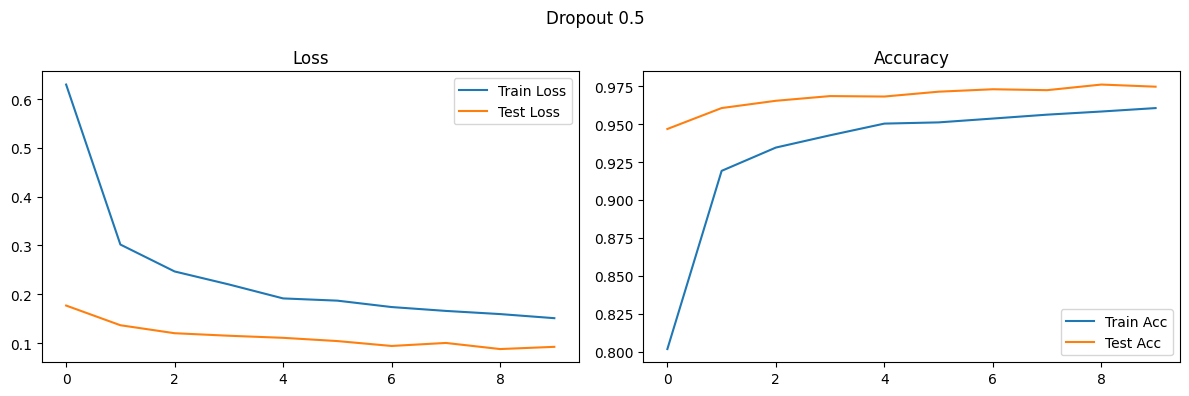

In [ ]:
layers_dropout = [
    {'type': 'linear', 'size': 256}, {'type': 'relu'}, {'type': 'dropout', 'rate': 0.5},
    {'type': 'linear', 'size': 128}, {'type': 'relu'}, {'type': 'dropout', 'rate': 0.5},
    {'type': 'linear', 'size': 64}, {'type': 'relu'}, {'type': 'dropout', 'rate': 0.5},
]
print("Только Dropout:")
config = {'layers': layers_dropout, 'input_size': INPUT_DIM, 'num_classes': OUTPUT_DIM}
model = FullyConnectedModel(**config).to(device)
history_dropout = train_model(model, train_loader, test_loader, epochs=10, lr=0.001, device=device)
plot_training_history(history_dropout, title='Dropout 0.5')

Только BatchNorm:
Epoch 1/10:
Train Loss: 0.2547, Train Acc: 0.9417
Test Loss: 0.0934, Test Acc: 0.9729
--------------------------------------------------
Epoch 2/10:
Train Loss: 0.0816, Train Acc: 0.9756
Test Loss: 0.0818, Test Acc: 0.9733
--------------------------------------------------
Epoch 3/10:
Train Loss: 0.0564, Train Acc: 0.9821
Test Loss: 0.0687, Test Acc: 0.9792
--------------------------------------------------
Epoch 4/10:
Train Loss: 0.0397, Train Acc: 0.9876
Test Loss: 0.0690, Test Acc: 0.9777
--------------------------------------------------
Epoch 5/10:
Train Loss: 0.0298, Train Acc: 0.9905
Test Loss: 0.0726, Test Acc: 0.9787
--------------------------------------------------
Epoch 6/10:
Train Loss: 0.0272, Train Acc: 0.9909
Test Loss: 0.0687, Test Acc: 0.9794
--------------------------------------------------
Epoch 7/10:
Train Loss: 0.0223, Train Acc: 0.9925
Test Loss: 0.0657, Test Acc: 0.9814
--------------------------------------------------
Epoch 8/10:
Train Loss:

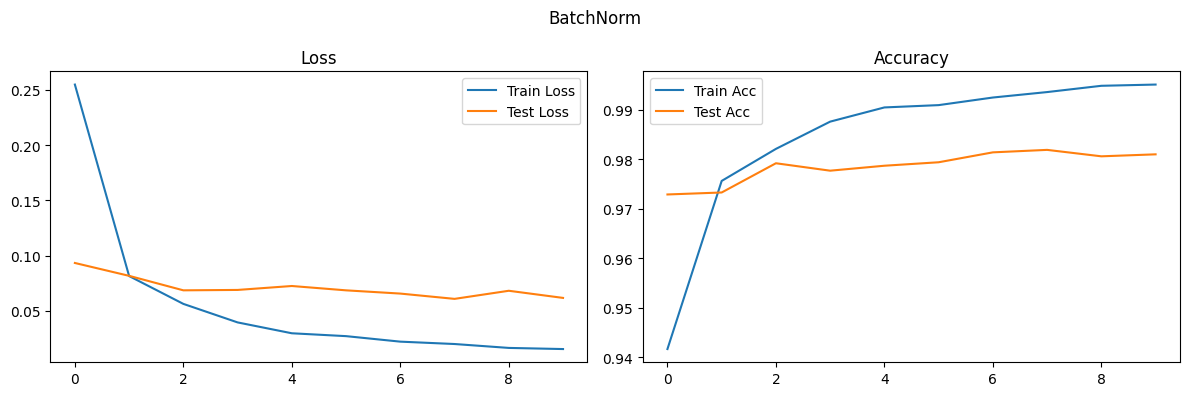

In [ ]:
# Только BatchNorm
layers_bn = [
    {'type': 'linear', 'size': 256}, {'type': 'batch_norm'}, {'type': 'relu'},
    {'type': 'linear', 'size': 128}, {'type': 'batch_norm'}, {'type': 'relu'},
    {'type': 'linear', 'size': 64}, {'type': 'batch_norm'}, {'type': 'relu'},
]
print("Только BatchNorm:")
config = {'layers': layers_bn, 'input_size': INPUT_DIM, 'num_classes': OUTPUT_DIM}
model = FullyConnectedModel(**config).to(device)
history_bn = train_model(model, train_loader, test_loader, epochs=10, lr=0.001, device=device)
plot_training_history(history_bn, title='BatchNorm')

Dropout + BatchNorm:
Epoch 1/10:
Train Loss: 0.6969, Train Acc: 0.8108
Test Loss: 0.1801, Test Acc: 0.9475
--------------------------------------------------
Epoch 2/10:
Train Loss: 0.3332, Train Acc: 0.9102
Test Loss: 0.1321, Test Acc: 0.9621
--------------------------------------------------
Epoch 3/10:
Train Loss: 0.2681, Train Acc: 0.9269
Test Loss: 0.1128, Test Acc: 0.9677
--------------------------------------------------
Epoch 4/10:
Train Loss: 0.2368, Train Acc: 0.9365
Test Loss: 0.0942, Test Acc: 0.9719
--------------------------------------------------
Epoch 5/10:
Train Loss: 0.2139, Train Acc: 0.9435
Test Loss: 0.0861, Test Acc: 0.9732
--------------------------------------------------
Epoch 6/10:
Train Loss: 0.1947, Train Acc: 0.9475
Test Loss: 0.0845, Test Acc: 0.9755
--------------------------------------------------
Epoch 7/10:
Train Loss: 0.1811, Train Acc: 0.9520
Test Loss: 0.0798, Test Acc: 0.9760
--------------------------------------------------
Epoch 8/10:
Train Lo

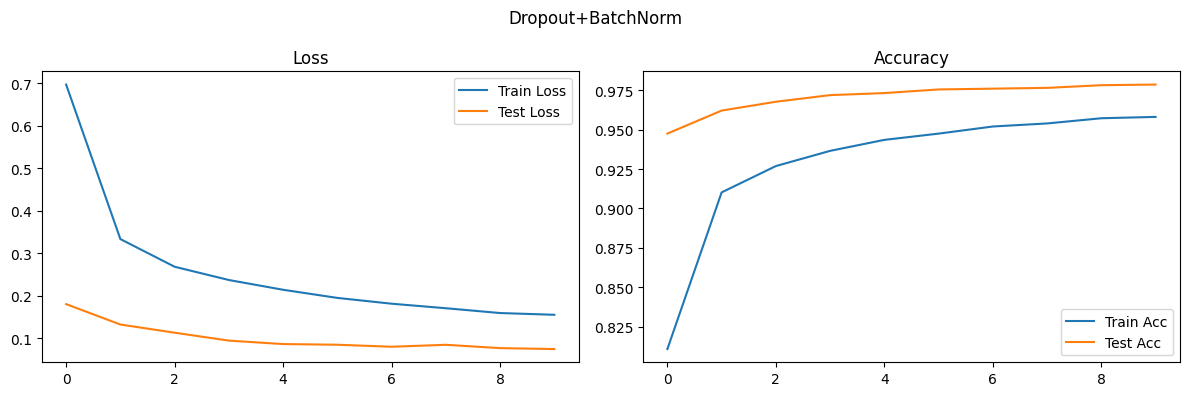

In [ ]:
# Dropout + BatchNorm
layers_dbn = [
    {'type': 'linear', 'size': 256}, {'type': 'batch_norm'}, {'type': 'relu'}, {'type': 'dropout', 'rate': 0.5},
    {'type': 'linear', 'size': 128}, {'type': 'batch_norm'}, {'type': 'relu'}, {'type': 'dropout', 'rate': 0.5},
    {'type': 'linear', 'size': 64}, {'type': 'batch_norm'}, {'type': 'relu'}, {'type': 'dropout', 'rate': 0.5},
]
print("Dropout + BatchNorm:")
config = {'layers': layers_dbn, 'input_size': INPUT_DIM, 'num_classes': OUTPUT_DIM}
model = FullyConnectedModel(**config).to(device)
history_dbn = train_model(model, train_loader, test_loader, epochs=10, lr=0.001, device=device)
plot_training_history(history_dbn, title='Dropout+BatchNorm')

L2 регуляризация:
Epoch 1/10:
Train Loss: 0.3701, Train Acc: 0.8930
Test Loss: 0.1989, Test Acc: 0.9390
--------------------------------------------------
Epoch 2/10:
Train Loss: 0.1993, Train Acc: 0.9436
Test Loss: 0.1759, Test Acc: 0.9472
--------------------------------------------------
Epoch 3/10:
Train Loss: 0.1803, Train Acc: 0.9487
Test Loss: 0.1748, Test Acc: 0.9491
--------------------------------------------------
Epoch 4/10:
Train Loss: 0.1645, Train Acc: 0.9544
Test Loss: 0.1622, Test Acc: 0.9557
--------------------------------------------------
Epoch 5/10:
Train Loss: 0.1569, Train Acc: 0.9564
Test Loss: 0.1402, Test Acc: 0.9598
--------------------------------------------------
Epoch 6/10:
Train Loss: 0.1498, Train Acc: 0.9585
Test Loss: 0.1376, Test Acc: 0.9638
--------------------------------------------------
Epoch 7/10:
Train Loss: 0.1462, Train Acc: 0.9597
Test Loss: 0.1330, Test Acc: 0.9626
--------------------------------------------------
Epoch 8/10:
Train Loss:

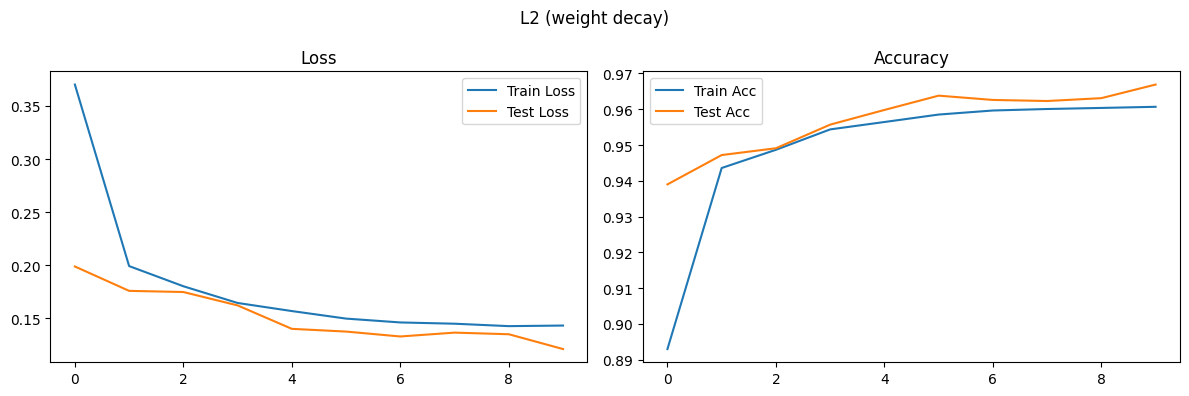

In [ ]:
# L2 регуляризация (weight decay)
print("L2 регуляризация:")
model = FullyConnectedModel(**{'layers': layers, 'input_size': INPUT_DIM, 'num_classes': OUTPUT_DIM}).to(device)
def train_with_weight_decay(model, train_loader, test_loader, epochs=10, lr=0.001, wd=0.01, device='cpu'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    train_losses, train_accs = [], []
    test_losses, test_accs = [], []
    for epoch in range(epochs):
        train_loss, train_acc = run_epoch(model, train_loader, criterion, optimizer, device, is_test=False)
        test_loss, test_acc = run_epoch(model, test_loader, criterion, None, device, is_test=True)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
        print('-' * 50)
    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_losses': test_losses,
        'test_accs': test_accs
    }
history_l2 = train_with_weight_decay(model, train_loader, test_loader, epochs=10, lr=0.001, wd=0.01, device=device)
plot_training_history(history_l2, title='L2 (weight decay)')

## Лучше всего показывает себя BatchNorm (или BatchNorm+Dropout). Без регуляризации модель показывает отличный train, но может переобучиться на test.



## 3.2 Адаптивная регуляризация (10 баллов)

In [ ]:
# Реализуйте адаптивные техники:
# - Dropout с изменяющимся коэффициентом
# - BatchNorm с различными momentum
# - Комбинирование нескольких техник
# - Анализ влияния на разные слои сети

Dropout с разным коэффициентом по слоям:
Epoch 1/10:
Train Loss: 0.4769, Train Acc: 0.8581
Test Loss: 0.1596, Test Acc: 0.9509
--------------------------------------------------
Epoch 2/10:
Train Loss: 0.1889, Train Acc: 0.9504
Test Loss: 0.1205, Test Acc: 0.9659
--------------------------------------------------
Epoch 3/10:
Train Loss: 0.1432, Train Acc: 0.9630
Test Loss: 0.1013, Test Acc: 0.9716
--------------------------------------------------
Epoch 4/10:
Train Loss: 0.1146, Train Acc: 0.9699
Test Loss: 0.0885, Test Acc: 0.9744
--------------------------------------------------
Epoch 5/10:
Train Loss: 0.0928, Train Acc: 0.9754
Test Loss: 0.0902, Test Acc: 0.9753
--------------------------------------------------
Epoch 6/10:
Train Loss: 0.0808, Train Acc: 0.9780
Test Loss: 0.0893, Test Acc: 0.9775
--------------------------------------------------
Epoch 7/10:
Train Loss: 0.0741, Train Acc: 0.9798
Test Loss: 0.0790, Test Acc: 0.9796
--------------------------------------------------


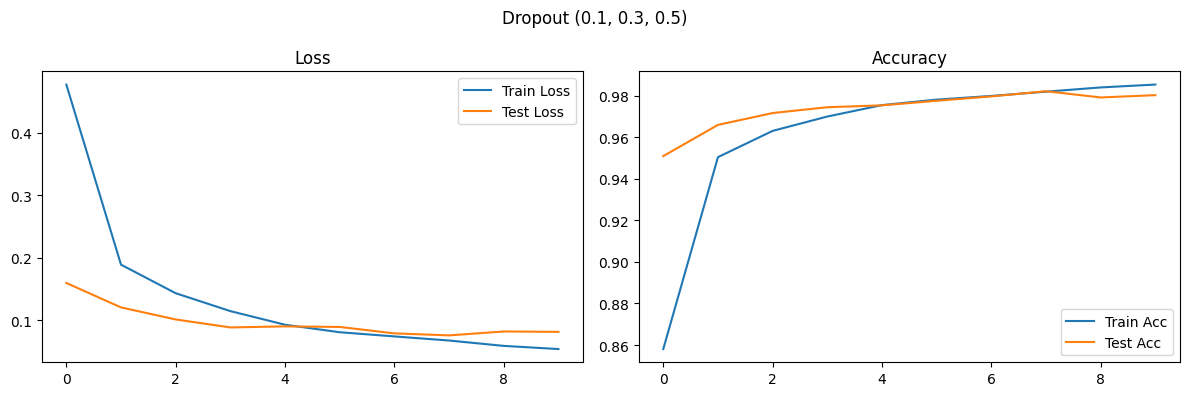

In [ ]:
layers = [
    {'type': 'linear', 'size': 256}, {'type': 'relu'}, {'type': 'dropout', 'rate': 0.1},
    {'type': 'linear', 'size': 128}, {'type': 'relu'}, {'type': 'dropout', 'rate': 0.3},
    {'type': 'linear', 'size': 64},  {'type': 'relu'}, {'type': 'dropout', 'rate': 0.5},
]
config = {'layers': layers, 'input_size': INPUT_DIM, 'num_classes': OUTPUT_DIM}
model = FullyConnectedModel(**config).to(device)
print("Dropout с разным коэффициентом по слоям:")
history = train_model(model, train_loader, test_loader, epochs=10, lr=0.001, device=device)
plot_training_history(history, title='Dropout (0.1, 0.3, 0.5)')


In [ ]:
class FullyConnectedModelAdaptiveBN(FullyConnectedModel):
    def _build_layers(self):
        layers = []
        prev_size = self.input_size
        layer_config = self.config.get('layers', [])
        for i, layer_spec in enumerate(layer_config):
            layer_type = layer_spec['type']
            if layer_type == 'linear':
                out_size = layer_spec['size']
                layers.append(nn.Linear(prev_size, out_size))
                prev_size = out_size
            elif layer_type == 'relu':
                layers.append(nn.ReLU())
            elif layer_type == 'sigmoid':
                layers.append(nn.Sigmoid())
            elif layer_type == 'tanh':
                layers.append(nn.Tanh())
            elif layer_type == 'dropout':
                rate = layer_spec.get('rate', 0.5)
                layers.append(nn.Dropout(rate))
            elif layer_type == 'batch_norm':
                momentum = layer_spec.get('momentum', 0.1)
                layers.append(nn.BatchNorm1d(prev_size, momentum=momentum))
            elif layer_type == 'layer_norm':
                layers.append(nn.LayerNorm(prev_size))
        layers.append(nn.Linear(prev_size, self.num_classes))
        return nn.Sequential(*layers)

BatchNorm с разными momentum:
Epoch 1/10:
Train Loss: 0.2648, Train Acc: 0.9388
Test Loss: 0.1000, Test Acc: 0.9707
--------------------------------------------------
Epoch 2/10:
Train Loss: 0.0832, Train Acc: 0.9753
Test Loss: 0.0750, Test Acc: 0.9772
--------------------------------------------------
Epoch 3/10:
Train Loss: 0.0569, Train Acc: 0.9824
Test Loss: 0.0684, Test Acc: 0.9780
--------------------------------------------------
Epoch 4/10:
Train Loss: 0.0391, Train Acc: 0.9879
Test Loss: 0.0624, Test Acc: 0.9799
--------------------------------------------------
Epoch 5/10:
Train Loss: 0.0316, Train Acc: 0.9897
Test Loss: 0.0713, Test Acc: 0.9786
--------------------------------------------------
Epoch 6/10:
Train Loss: 0.0262, Train Acc: 0.9912
Test Loss: 0.0608, Test Acc: 0.9807
--------------------------------------------------
Epoch 7/10:
Train Loss: 0.0209, Train Acc: 0.9932
Test Loss: 0.0611, Test Acc: 0.9829
--------------------------------------------------
Epoch 8/10:

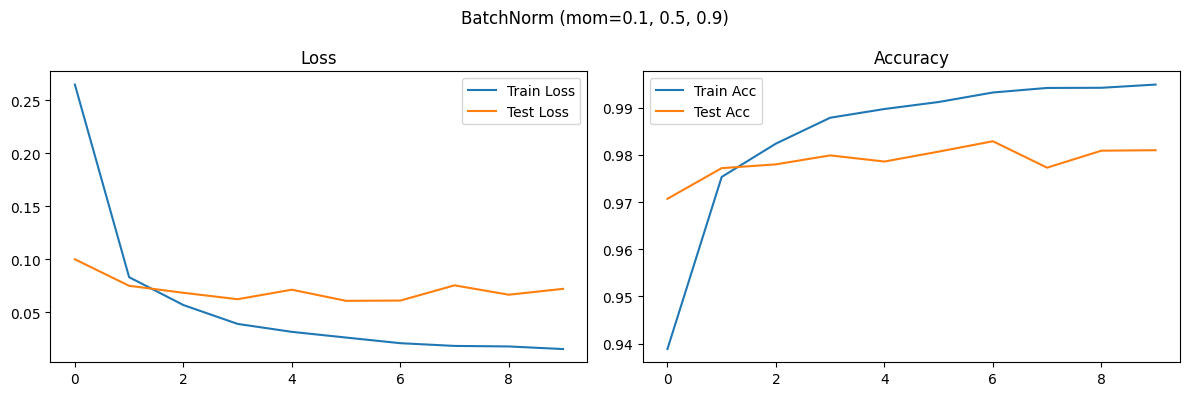

In [ ]:
layers = [
    {'type': 'linear', 'size': 256}, {'type': 'batch_norm', 'momentum': 0.1}, {'type': 'relu'},
    {'type': 'linear', 'size': 128}, {'type': 'batch_norm', 'momentum': 0.5}, {'type': 'relu'},
    {'type': 'linear', 'size': 64},  {'type': 'batch_norm', 'momentum': 0.9}, {'type': 'relu'},
]
config = {'layers': layers, 'input_size': INPUT_DIM, 'num_classes': OUTPUT_DIM}
model = FullyConnectedModelAdaptiveBN(**config).to(device)
print("BatchNorm с разными momentum:")
history = train_model(model, train_loader, test_loader, epochs=10, lr=0.001, device=device)
plot_training_history(history, title='BatchNorm (mom=0.1, 0.5, 0.9)')


BatchNorm + Dropout, адаптивно:
Epoch 1/10:
Train Loss: 0.4327, Train Acc: 0.8841
Test Loss: 0.1212, Test Acc: 0.9621
--------------------------------------------------
Epoch 2/10:
Train Loss: 0.1788, Train Acc: 0.9522
Test Loss: 0.0914, Test Acc: 0.9718
--------------------------------------------------
Epoch 3/10:
Train Loss: 0.1418, Train Acc: 0.9621
Test Loss: 0.0796, Test Acc: 0.9746
--------------------------------------------------
Epoch 4/10:
Train Loss: 0.1158, Train Acc: 0.9685
Test Loss: 0.0753, Test Acc: 0.9780
--------------------------------------------------
Epoch 5/10:
Train Loss: 0.1019, Train Acc: 0.9727
Test Loss: 0.0773, Test Acc: 0.9771
--------------------------------------------------
Epoch 6/10:
Train Loss: 0.0872, Train Acc: 0.9749
Test Loss: 0.0713, Test Acc: 0.9802
--------------------------------------------------
Epoch 7/10:
Train Loss: 0.0794, Train Acc: 0.9778
Test Loss: 0.0652, Test Acc: 0.9807
--------------------------------------------------
Epoch 8/1

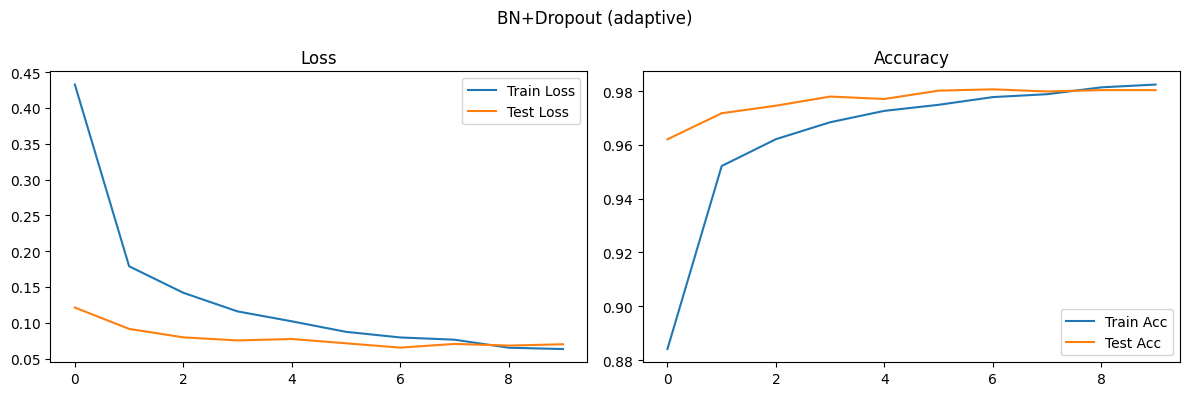

In [ ]:
layers = [
    {'type': 'linear', 'size': 256}, {'type': 'batch_norm', 'momentum': 0.2}, {'type': 'relu'}, {'type': 'dropout', 'rate': 0.1},
    {'type': 'linear', 'size': 128}, {'type': 'batch_norm', 'momentum': 0.7}, {'type': 'relu'}, {'type': 'dropout', 'rate': 0.4},
    {'type': 'linear', 'size': 64},  {'type': 'relu'}, {'type': 'dropout', 'rate': 0.5},
]
config = {'layers': layers, 'input_size': INPUT_DIM, 'num_classes': OUTPUT_DIM}
model = FullyConnectedModelAdaptiveBN(**config).to(device)
print("BatchNorm + Dropout, адаптивно:")
history = train_model(model, train_loader, test_loader, epochs=10, lr=0.001, device=device)
plot_training_history(history, title='BN+Dropout (adaptive)')


## Все техники регуляризации работают — при правильных параметрах дают стабильную и высокую точность.

## BatchNorm чуть лучше на трейне, но test accuracy примерно одинакова для всех трёх методов.